**Medical Malpractice**

This model predicts whether or not a medical malpractice claim will result in a catastrophic payout given input features. We define catastrophic as exceeding a certain threshold set by the model user (i.e. the user of the model may specify catastrophic as exceeding $1,000,000 in payout)

Selected variables:

Outputs:
- Whether or not the claim will be catastrophic*. Output: (True/False)
- The probability that the claim will be catastrophic. Output: (Probability value from 0 to 1)

- Expected claim payout in the event of a catastrophic payout. Output: Dollar value
- Probability distribution of payout (25th, 50th, 75th percentile etc.)




**Setup**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install pandasql
import pandasql as ps

Spark setup

In [ ]:
%%capture
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
%%capture
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import os

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
%%capture
import os
os.environ['SPARK_HOME'] = "/content/spark-3.1.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
 #spark = SparkSession.builder.appName('Initial').getOrCreate()
 #sqlContext=SQLContext(spark)

In [ ]:
%%capture
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

EMR Cluster Setup

In [ ]:
%spark delete -s my_session

An error was encountered:
Could not find 'my_session' session in list of saved sessions. Possible sessions are []


In [ ]:
%spark add -s my_session -l python -u http://ec2-54-147-101-225.compute-1.amazonaws.com:8998

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1621521432932_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


**I. Data Preprocessing and Feature Engineering**

Data preprocessing task list:
- Adjust payment feature for inflation
- Calculate years of experience
- Add "catastrophic" column (1 if payment exceeds threshold, 0 if it does not)

In [ ]:
%%spark

spark_reader = spark.read
sdf = spark_reader.csv('content/drive/MyDrive/Practicum/NPDB2010.CSV', header = True)
#sdf = spark_reader.load('/C:/Users/Phil/Desktop/Practicum/NPDB2010.CSV', format = 'csv', header = True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
Path does not exist: hdfs://ip-172-31-15-99.ec2.internal:8020/user/livy/content/drive/MyDrive/Practicum/NPDB2010.CSV;
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/readwriter.py", line 535, in csv
    return self._df(self._jreader.csv(self._spark._sc._jvm.PythonUtils.toSeq(path)))
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1305, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 137, in deco
    raise_from(converted)
  File "<string>", line 3, in raise_from
pyspark.sql.utils.AnalysisException: Path does not exist: hdfs://ip-172-31-15-99.ec2.internal:8020/user/livy/content/drive/MyDrive/Practicum/NPDB2010.CSV;



In [ ]:
%%spark
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/Practicum/NPDB2010.CSV')
df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
[Errno 2] File /content/drive/MyDrive/Practicum/NPDB2010.CSV does not exist: '/content/drive/MyDrive/Practicum/NPDB2010.CSV'
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/pandas/io/parsers.py", line 676, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib64/python3.7/site-packages/pandas/io/parsers.py", line 448, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/usr/local/lib64/python3.7/site-packages/pandas/io/parsers.py", line 880, in __init__
    self._make_engine(self.engine)
  File "/usr/local/lib64/python3.7/site-packages/pandas/io/parsers.py", line 1114, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/usr/local/lib64/python3.7/site-packages/pandas/io/parsers.py", line 1891, in __init__
    self._reader = parsers.TextReader(src, **kwds)
  File "pandas/_libs/parsers.pyx", line 374, in pandas._libs.parsers.TextReader.__cinit__
  File "pandas/_l

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'df' is not defined
Traceback (most recent call last):
NameError: name 'df' is not defined



In [ ]:
x = '$7500'

def to_float(x):
  if isinstance(x, str) and x[0] == '$':
    x = float(x[1:])
  return x
  
y = to_float(x)
print(str(type(x)) == 'str')
print(y)

False
7500.0


In [ ]:
df['TOTALPMT_FLOAT'] = df['TOTALPMT'].apply(lambda x: to_float(x))
df.dtypes

SEQNO               int64
RECTYPE            object
REPTYPE             int64
ORIGYEAR            int64
WORKSTAT           object
WORKCTRY          float64
HOMESTAT           object
HOMECTRY          float64
LICNSTAT           object
LICNFELD            int64
PRACTAGE          float64
GRAD              float64
ALGNNATR          float64
ALEGATN1          float64
ALEGATN2          float64
OUTCOME           float64
MALYEAR1          float64
MALYEAR2          float64
PAYMENT            object
TOTALPMT           object
PAYNUMBR           object
NUMBPRSN          float64
PAYTYPE            object
PYRRLTNS           object
PTAGE             float64
PTGENDER           object
PTTYPE             object
AAYEAR            float64
AACLASS1          float64
AACLASS2          float64
AACLASS3          float64
AACLASS4          float64
AACLASS5          float64
BASISCD1           object
BASISCD2           object
BASISCD3           object
BASISCD4           object
BASISCD5           object
AALENTYP    

Converting from pandas DF to spark DF.

Below is a handy set of functions to convert from Pandas DF to Spark DF (written by Gonzalo Garcia, github: zaloogarcia).
[Page](https://https://gist.github.com/zaloogarcia/11508e9ca786c6851513d31fb2e70bfc)


In [ ]:

from pyspark.sql.types import *

# Auxiliar functions
# Pandas Types -> Sparks Types
def equivalent_type(f):
  if f == 'datetime64[ns]': return DateType()
  elif f == 'int64': return LongType()
  elif f == 'int32': return IntegerType()
  elif f == 'float64': return FloatType()
  else: return StringType()

def define_structure(string, format_type):
  try: typo = equivalent_type(format_type)
  except: typo = StringType()
  return StructField(string, typo)

#Given pandas dataframe, it will return a spark's dataframe
def pandas_to_spark(df_pandas):
  columns = list(df_pandas.columns)
  types = list(df_pandas.dtypes)
  struct_list = []
  for column, typo in zip(columns, types): 
    struct_list.append(define_structure(column, typo))
  p_schema = StructType(struct_list)
  return sqlContext.createDataFrame(df_pandas, p_schema)

In [ ]:
sdf = pandas_to_spark(df)

In [ ]:
sdf.show(10)

KeyboardInterrupt: ignored

In [ ]:

# create spark dataframe
# sdf = spark.createDataFrame(df)
spark_reader = spark.read
sdf = spark_reader.load('/content/drive/MyDrive/Practicum/NPDB2010.CSV', format = 'csv', header = True)

In [ ]:
sdf.dtypes

[('SEQNO', 'string'),
 ('RECTYPE', 'string'),
 ('REPTYPE', 'string'),
 ('ORIGYEAR', 'string'),
 ('WORKSTAT', 'string'),
 ('WORKCTRY', 'string'),
 ('HOMESTAT', 'string'),
 ('HOMECTRY', 'string'),
 ('LICNSTAT', 'string'),
 ('LICNFELD', 'string'),
 ('PRACTAGE', 'string'),
 ('GRAD', 'string'),
 ('ALGNNATR', 'string'),
 ('ALEGATN1', 'string'),
 ('ALEGATN2', 'string'),
 ('OUTCOME', 'string'),
 ('MALYEAR1', 'string'),
 ('MALYEAR2', 'string'),
 ('PAYMENT', 'string'),
 ('TOTALPMT', 'string'),
 ('PAYNUMBR', 'string'),
 ('NUMBPRSN', 'string'),
 ('PAYTYPE', 'string'),
 ('PYRRLTNS', 'string'),
 ('PTAGE', 'string'),
 ('PTGENDER', 'string'),
 ('PTTYPE', 'string'),
 ('AAYEAR', 'string'),
 ('AACLASS1', 'string'),
 ('AACLASS2', 'string'),
 ('AACLASS3', 'string'),
 ('AACLASS4', 'string'),
 ('AACLASS5', 'string'),
 ('BASISCD1', 'string'),
 ('BASISCD2', 'string'),
 ('BASISCD3', 'string'),
 ('BASISCD4', 'string'),
 ('BASISCD5', 'string'),
 ('AALENTYP', 'string'),
 ('AALENGTH', 'string'),
 ('AAEFYEAR', 'stri

In [ ]:
# This is to check if all the totalpmt has been converted

query = '''
SELECT COUNT(*)
FROM df
WHERE TOTALPMT IS NOT NULL
'''

query_df = ps.sqldf(query, locals())
query_df

In [ ]:
df.shape

In [ ]:
spark_reader = spark.read

In [ ]:
sdf = spark_reader.load('/content/drive/MyDrive/Practicum/NPDB2010.CSV', format = 'csv', header = True)
sdf.createOrReplaceTempView('sdf')

In [ ]:
sdf.show(10)

In [ ]:
sdf.dtypes

I.a. Adjusting Payment Data for Inflation

First we bring in data from Bureau Labor of Statistics and merge inflation factor into the table.

In [ ]:
inf_df = pd.read_excel('/content/drive/MyDrive/Practicum/CPI_inf_factor.xlsx')
inf_sdf = spark.createDataFrame(inf_df)
inf_sdf.createOrReplaceTempView('inf_sdf')
inf_sdf.show(10)

In [ ]:
inf_sdf.dtypes

Next we join the inflation dataframe with the main dataframe (inf_sdf with sdf)

In [ ]:
query = '''
SELECT *, INF * TOTALPMT AS INF_TOTALPMT 
FROM sdf JOIN inf_sdf ON sdf.ORIGYEAR = inf_sdf.From_Year
'''

sdf_1 = spark.sql(query)
sdf_1.show(10)

In [ ]:
print((sdf_1.count(), len(sdf_1.columns)))

In [ ]:
#df_1 = pd.merge(df, inf_df, left_on = 'ORIGYEAR', right_on = 'From-Year', how = 'left')
#df_1['ADJ_TOTALPMT'] = df_1['TOTALPMT'].apply(lambda x: x * df_1['INF'])
#df_1

In [ ]:
min_year = df['ORIGYEAR'].drop_duplicates()
min_year

Change data type of total PMT to integer

In [ ]:
df['TOTALPMT'].dtype
df['TOTALPMT']

I. **Exploratory Data Analysis**

To do:

1. See correlation between 

Final: Select indicator features:
Indicator features selected:
- Practitioner age
- Practitioner experience
- Patient type
- Malpractice Act (ALGNNATR)



**I.I Payment Data Analysis**

From NPDB Public Use Data File description pdf.

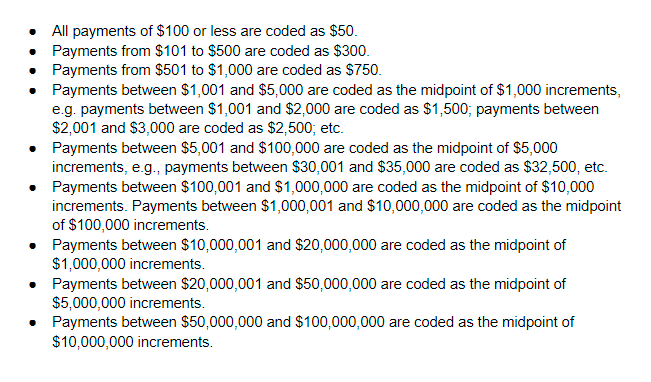



Out of ~1.5 million rows of data we have 223,926 rows which have information medical malpractice payment

In [ ]:
totalpmt_df = df.groupby(by = ["TOTALPMT"]).count()
sum_count = totalpmt_df['SEQNO'].sum() 
sum_count

In [ ]:
totalpmt_df.sort_values(by = ['TOTALPMT'])

**Inflationary Adjustment to PAYMENT and TOTALPMT attributes**

We use CPI information from the Bureau of Labor and Statistics Website to adjust for inflation.
https://www.bls.gov/cpi/home.htm

Notes: need to see if type of adverse action is known at the time claim is made.